In [140]:
# %matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l    
import random
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

from IPython import display

# d2l.use_svg_display() # 用svg来显示我们的图片, 更清晰.
# 就是再里面进行设置成svg模式.

In [141]:


def load_data_fashin_mnist(batch_size, resize=None) -> Tuple[DataLoader, DataLoader]: # 需要使用[]
    trans = [transforms.ToTensor()]
    if resize:  # 判空
        trans.append(transforms.Resize(resize))
    trans = transforms.Compose(trans)
    fashion_mnist_train = torchvision.datasets.FashionMNIST("../data", train=True, transform=trans, download=True)
    fashion_mnist_val = torchvision.datasets.FashionMNIST("../data/", train=False, transform=trans, download=False)
    
    fashion_mnist_train_dataloader = DataLoader(fashion_mnist_train, batch_size, True, num_workers=16)
    fashion_mnist_val_dataloader = DataLoader(fashion_mnist_val, batch_size, True, num_workers=16)
    
    return fashion_mnist_train_dataloader, fashion_mnist_val_dataloader
    
    

In [142]:
batch_size = 256
train_dataloader, test_dataloader = load_data_fashin_mnist(batch_size)

In [143]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


In [144]:
y = torch.tensor([0, 2]) # 这里表示两个真实的标号, 就是一组batch. 那个是正确类别, 这里假设第一个example y_true是0, 第二个example y_true是2.
y_hat = torch.tensor([
    [0.1, 0.3, 0.6], 
    [0.3, 0.2, 0.5]
])


In [145]:
def softamx(X) -> torch.Tensor:
    X = torch.exp(X)
    return X / X.sum(dim=1, keepdim=True) # broadcast operation

softamx(y_hat)

tensor([[0.2584, 0.3156, 0.4260],
        [0.3199, 0.2894, 0.3907]])

In [146]:
# 定义模型:
def net(X:torch.Tensor) -> torch.Tensor:
    return softamx(X.reshape(-1, W.shape[0]) @ W + b)



In [147]:
# loss function:
def cross_entropy(y_hat, y) -> torch.Tensor:
    return - torch.log(y_hat[range(len(y)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [148]:
# 计算accuracy:
def accuracy(y_hat: torch.Tensor, y: torch.Tensor) -> float:
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:  # 二维, 并且列数要大于1.
        y_hat = y_hat.argmax(dim=1)  # 返回指定轴上值最大的索引. 这里是按照行为单位, 所以dim=1
    cmp = y_hat.type(y.dtype) == y # 转换为同一种类型.
    return float(cmp.type(y.dtype).sum()) # 这里求和. 所以需要在外面减去. 
    # 因为我们不知道这一批量具体是多少, 所以我们在Accumulate中进行计算精度的操作. 

    
accuracy(y_hat, y) / len(y) # 除以这一批量的大小. 


0.5

In [149]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data) # 重置。 

    def __getitem__(self, idx):
        return self.data[idx]

In [150]:
# 评估精度:
def eval_accuracy(net, test_data_iter:DataLoader) -> float:
    if isinstance(net, torch.nn.Module): # 判断是不是Module模块
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in test_data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
        

In [151]:
eval_accuracy(net, test_dataloader)

0.0537

In [152]:
# 训练函数: 
def train_epoch_ch3(net, train_dataloader, loss, optimizer):
    """训练模型为一个迭代周期."""
    if isinstance(net, torch.nn.Module):
        net.train() # 开启训练模式, 计算梯度, 并且启动某些特定的layer
        
    metric = Accumulator(3) # 累加器.
    for x, y in train_dataloader:
        y_hat = net(x)
        l = loss(y_hat, y)
        
        if isinstance(optimizer, torch.optim.Optimizer): # 如果是Optimizer对象的话.
            optimizer.zero_grad()
            l.mean().backward()
            optimizer.step()
        else:
            l.sum().backward()
            optimizer(x.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]
    # 返回平均损失, 以及准确率.  
    

In [153]:
# 辅助函数, 帮助我们显示一些动画. 
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [154]:
# 总的训练函数:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = eval_accuracy(net, test_iter)
        
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [155]:
lr = 0.1
# 封装一下我们的sgd优化器. 
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

AttributeError: 'function' object has no attribute 'display'

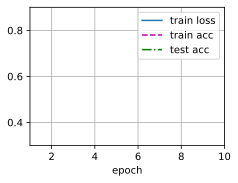

In [156]:
num_epochs = 10 # 先设置10个epoch
train_ch3(net, train_dataloader, test_dataloader, cross_entropy, num_epochs, updater) # 训练

# 通过我们设置不同的batchsize, 以及不同lr, 不同的epoch轮数, 我们可以看到不同的效果.